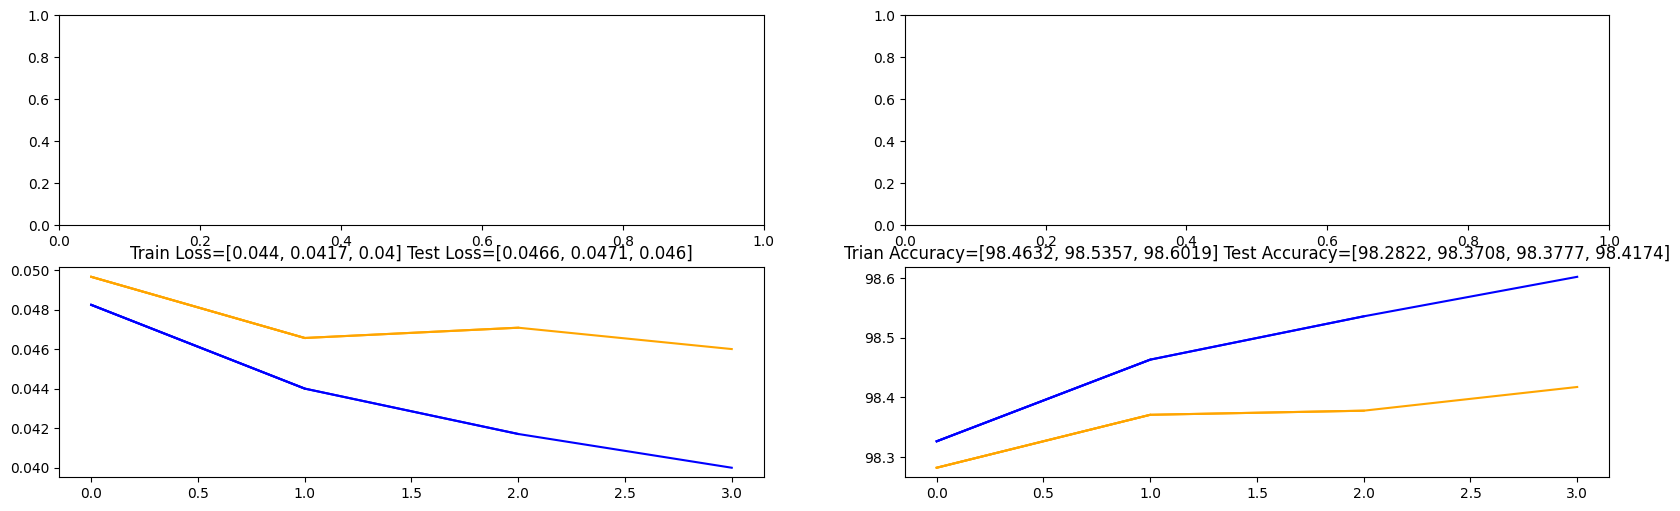

-------epoch------:4 time:282.05s current_lr:0.001,current_patience:0
Gradient for embedding.weight: 0.011366498656570911
Gradient for rnn.weight_ih_l0: 0.029253166168928146
Gradient for rnn.weight_hh_l0: 0.007403154391795397
Gradient for rnn.bias_ih_l0: 0.004391018766909838
Gradient for rnn.bias_hh_l0: 0.004391018766909838
Gradient for fc.weight: 0.012717495672404766
Gradient for fc.bias: 0.0038525674026459455


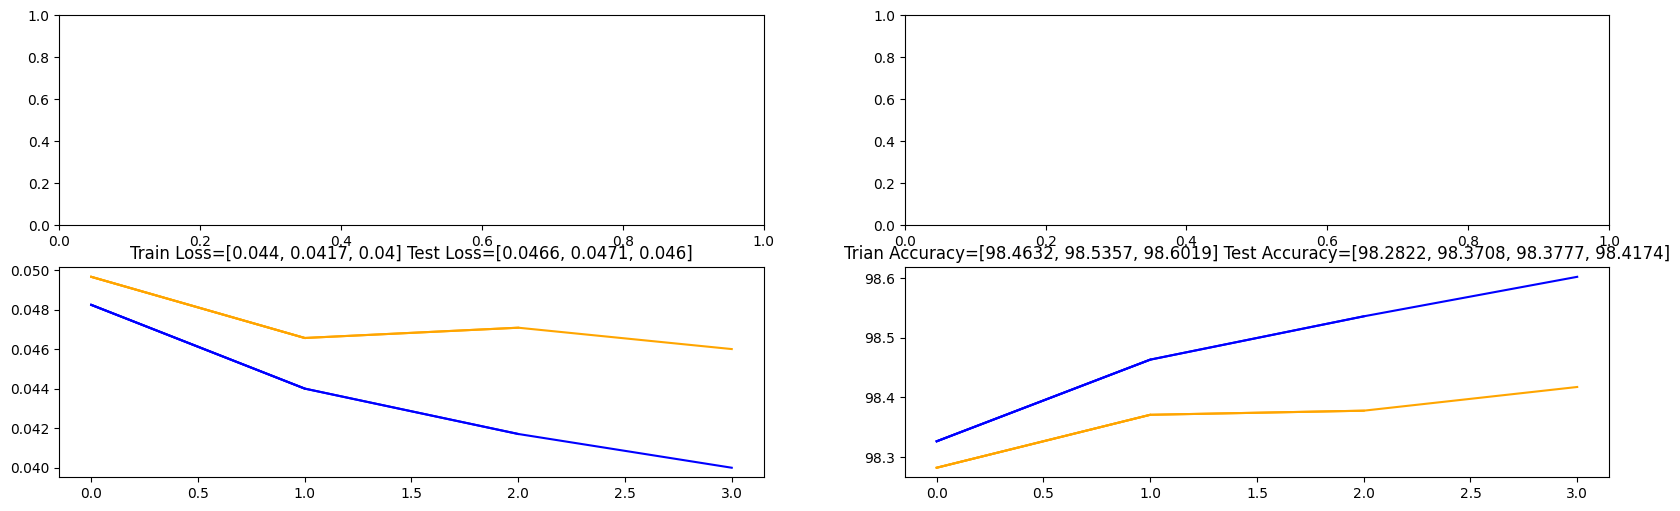

In [4]:
import torch
from torch.utils.data import DataLoader,random_split
from module import Module1
import read_data
from name_data import NameData
import torch.nn as nn
import matplotlib.pyplot as plt 
from IPython.display import clear_output,display
import time
import numpy as np

names,non_names = read_data.read()
dataset = NameData(names,non_names)

train_size = int(len(dataset)*0.8)
test_size = len(dataset) - train_size

train_set, test_set = random_split(dataset,[train_size,test_size])

train_loader = DataLoader(train_set,batch_size=32,shuffle=True)
test_loader = DataLoader(test_set,batch_size=32,shuffle=True)

# 创建和训练模型的简单示例
vocab_size = 65536  # 假设最大 Unicode 码点
embedding_dim = 50
hidden_dim = 20

model = Module1(vocab_size, embedding_dim, hidden_dim)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

from train import accuracy_fn,train_step,test_step

best_loss = float('inf')
patience= 10
current_patience = 0
epochs = 5


test_losses= []
test_accs = []
train_losses = []
train_accs = []

fig, ((epoch_loss_ax, epoch_acc_ax), (loss_ax, acc_ax)) = plt.subplots(2, 2, figsize=(20, 6), gridspec_kw={'height_ratios': [1, 1]})

device = 'mps'

for epoch in range(epochs):
    
    start_time = time.time()
    train_loss,train_acc,train_epoch_losses,trian_epoch_accs = train_step(module=model,data_loader=train_loader,loss_fn=loss_fn,optimizer=optimizer,device=device,accuracy_fn=accuracy_fn,axes=(epoch_loss_ax,epoch_acc_ax),fig=None)
    test_loss,test_acc = test_step(module=model,data_loader= test_loader,loss_fn= loss_fn,device=device,accuracy_fn=accuracy_fn,axes=(epoch_loss_ax,epoch_acc_ax),fig=None)

    if test_loss < best_loss:
        best_loss = test_loss
        current_patience = 0
    else:
        current_patience += 1
    if epoch > 0:
        clear_output(wait=True)
        train_losses.append(train_loss.detach().cpu().numpy())
        #train_losses.append(train_loss.cpu())
        train_accs.append(train_acc)
        test_losses.append(test_loss.detach().cpu().numpy())
        test_accs.append(test_acc)
        loss_ax.plot(train_losses,color = "blue" )
        loss_ax.plot(test_losses,color = "orange" )
        acc_ax.plot(train_accs,color = "blue")
        acc_ax.plot(test_accs,color = "orange")
        loss_ax.set_title(f'Train Loss={[ np.round(item,4) for item in train_losses[-3:]]} Test Loss={[ np.round(item,4) for item in test_losses[-3:]]}')
        acc_ax.set_title(f'Trian Accuracy={[ round(item,4) for item in train_accs[-3:]]} Test Accuracy={[ round(item,4) for item in test_accs[-5:]]}')
        display(fig)

    end_time = time.time()
    current_lr = optimizer.param_groups[0]['lr']
    print(f'-------epoch------:{epoch} time:{(end_time - start_time):.2f}s current_lr:{current_lr},current_patience:{current_patience}')
    for name, param in model.named_parameters():
        if param.grad is not None:
            print(f'Gradient for {name}: {param.grad.norm()}')
    if current_patience == patience:
        print(f'Early stopping! No improvement for {patience} consecutive epochs.')
        print(f"train loss:{[ np.round(item,4) for item in train_losses]}")
        print(f"test loss:{[ np.round(item,4) for item in test_losses]}")
        break

    if epoch % 10 == 0:
        print(f"last 10 loss:{[ np.round(item,4) for item in test_losses[-10:]]}")
plt.ioff()

torch.save(model, 'pth/entire_model.pth')








